# MURA | Abnormality detection

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: March 2019
- MURA Dataset: https://stanfordmlgroup.github.io/competitions/mura/
- Post in medium: https://medium.com/@pierre_guillou/fastai-the-new-radiology-tool-76f02c1e25bf
- Ref: Fastai v1 (Deep Learning library on PyTorch)

## What is MURA?

MURA (musculoskeletal radiographs) is a large dataset of bone X-rays. Algorithms are tasked with determining whether an X-ray study is normal or abnormal.

Musculoskeletal conditions affect more than 1.7 billion people worldwide, and are the most common cause of severe, long-term pain and disability, with 30 million emergency department visits annually and increasing. We hope that our dataset can lead to significant advances in medical imaging technologies which can diagnose at the level of experts, towards improving healthcare access in parts of the world where access to skilled radiologists is limited.

MURA is one of the largest public radiographic image datasets. We're making this dataset available to the community and hosting a competition to see if your models can perform as well as radiologists on the task.

## Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.widgets import *
import shutil

In [3]:
from fastai.callbacks import * 

In [4]:
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.48
cuda: True


In [29]:
import gc
import torch

## Data

### Data path

In [5]:
Config.data_path()

PosixPath('/home/jupyter/tutorials/data')

In [6]:
path = Config.data_path() / 'MURA-v1.1'
path.ls()

[PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/valid_labeled_studies.csv'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/valid'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/train_image_paths.csv'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/train_labeled_studies.csv'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/valid_image_paths.csv'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/train'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/data2')]

### csv

In [7]:
df_train = pd.read_csv(path / 'train_image_paths.csv', header=None, names=['image'])
df_train.image[0]

'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'

In [8]:
df_valid = pd.read_csv(path / 'valid_image_paths.csv', header=None, names=['image'])
df_valid.image[0]

'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png'

In [9]:
df_train_label = pd.read_csv(path / 'train_labeled_studies.csv', header=None, names=['image', 'label'])
df_train_label.head()

,image,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


### Create folder data2 to train models

In [10]:
# Create data2 with data to train our models
path_train = path / 'data2/train'
path_valid = path / 'data2/valid'
path_train.mkdir(parents=True, exist_ok=True)
path_valid.mkdir(parents=True, exist_ok=True)

In [11]:
path_train_neg = path_train / '0'
path_train_pos = path_train / '1'
path_train_neg.mkdir(parents=True, exist_ok=True)
path_train_pos.mkdir(parents=True, exist_ok=True)

path_valid_neg = path_valid / '0'
path_valid_pos = path_valid / '1'
path_valid_neg.mkdir(parents=True, exist_ok=True)
path_valid_pos.mkdir(parents=True, exist_ok=True)

### Get list of images

In [12]:
fnames_train = get_image_files(path/'train', recurse=True)
print(len(fnames_train))
fnames_train[:5]

36808


[PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/train/XR_FINGER/patient04021/study1_negative/image1.png'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/train/XR_FINGER/patient03816/study1_negative/image1.png'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/train/XR_FINGER/patient04345/study1_negative/image2.png'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/train/XR_FINGER/patient04345/study1_negative/image3.png'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/train/XR_FINGER/patient04345/study1_negative/image1.png')]

In [13]:
fnames_valid = get_image_files(path/'valid', recurse=True)
print(len(fnames_valid))
fnames_valid[:5]

3197


[PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/valid/XR_FINGER/patient11855/study1_negative/image1.png'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/valid/XR_FINGER/patient11606/study1_negative/image1.png'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/valid/XR_FINGER/patient11513/study1_negative/image1.png'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/valid/XR_FINGER/patient11911/study1_positive/image2.png'),
 PosixPath('/home/jupyter/tutorials/data/MURA-v1.1/valid/XR_FINGER/patient11911/study1_positive/image3.png')]

### Copy images into data2

In [38]:
pat_label = re.compile(r'/XR_([^/]+)/[^/]+/[^/]+/[^/]+.png$')
pat_patient = re.compile(r'/[^/]+/patient([^/]+)/[^/]+/[^/]+.png$')
pat_study = re.compile(r'/[^/]+/[^/]+/([^/]+)/[^/]+.png$')
# pat_study_negpos = re.compile(r'\\[^\\]+\\[^\\]+\\study\d+_([^\\]+)\\[^\\]+.png$')

In [39]:
%%time
# copy all train images in corresponding class folders under MURA-v1.1/data2/train
for src in fnames_train:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)  
    # create class folder if necessary
    if 'negative' in study:
        path_label = path_train_neg
    else:
        path_label = path_train_pos
    # copy image to its class folder
    img_name = label + '_patient' + patient + '_' + study + '_' + src.name
    dest = path_label / img_name
    shutil.copy(str(src), str(dest))

CPU times: user 3.42 s, sys: 6.41 s, total: 9.83 s
Wall time: 2min 22s


In [40]:
%%time
# copy all valid images in corresponding class folders under MURA-v1.1/data2/valid
for src in fnames_valid:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)  
    # create class folder if necessary
    if 'negative' in study:
        path_label = path_valid_neg
    else:
        path_label = path_valid_pos
    # copy image to its class folder
    img_name = label + '_patient' + patient + '_' + study + '_' + src.name
    dest = path_label / img_name
    shutil.copy(str(src), str(dest))

CPU times: user 336 ms, sys: 564 ms, total: 900 ms
Wall time: 11.4 s


### Number of studies 

In [14]:
pat_label = re.compile(r'/XR_([^/]+)/[^/]+/[^/]+/[^/]+.png$')
pat_patient = re.compile(r'/[^/]+/patient([^/]+)/[^/]+/[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^/]+/[^/]+.png$')

In [15]:
mura = ['elbow', 'finger', 'forearm', 'hand', 'humerus', 'shoulder', 'wrist']

study_train_dict = dict()
study_valid_dict = dict()

for m in mura:
    study_train_dict[m] = list()
    study_valid_dict[m] = list()
    
for src in fnames_train:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)
    # add to label list
    s = 'patient' + patient + '_' + study
    study_train_dict[label.lower()].append(s)

for src in fnames_valid:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)
    # add to label list
    s = 'patient' + patient + '_' + study
    study_valid_dict[label.lower()].append(s)

In [16]:
num_train_studies = 0
num_valid_studies = 0

for m in mura:
    # train
    myset = set(study_train_dict[m])
    num_train_studies += len(myset)
    # valid
    myset = set(study_valid_dict[m])
    num_valid_studies += len(myset)

In [17]:
# 207 studies in test
num_train_studies, num_valid_studies, num_train_studies + num_valid_studies + 207

(13457, 1199, 14863)

## Training with resnet34

### size = 112

In [93]:
size = 112
bs = 512

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs, 
                                  ).normalize(imagenet_stats)

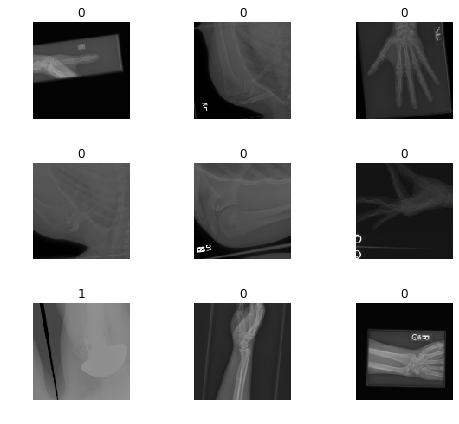

In [19]:
data.show_batch(rows=3, figsize=(7,6))

In [20]:
data.classes

['0', '1']

In [21]:
len(data.train_ds), len(data.valid_ds), len(data.train_ds) + len(data.valid_ds)

(36808, 3197, 40005)

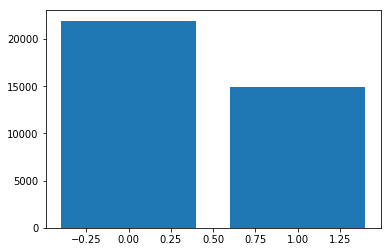

In [22]:
plt.bar([0,1], [len(path_train_neg.ls()), len(path_train_pos.ls())])
plt.show()

In [94]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], wd=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
1,0.777486,0.657900,0.380044,0.619956,20:09
2,0.656167,0.632573,0.353769,0.646231,12:55
3,0.614780,0.602607,0.324679,0.675321,12:23
4,0.592553,0.595166,0.322803,0.677197,12:34
5,0.585395,0.598298,0.325618,0.674382,12:44


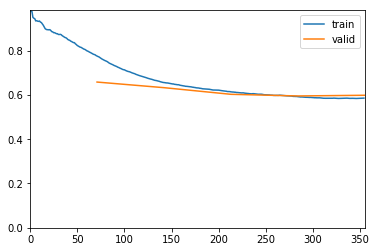

Better model found at epoch 1 with val_loss value: 0.6579000353813171.
Better model found at epoch 2 with val_loss value: 0.6325731873512268.
Better model found at epoch 3 with val_loss value: 0.6026073694229126.
Better model found at epoch 4 with val_loss value: 0.5951657891273499.


In [17]:
learn.fit_one_cycle(5,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.767645,0.673345,0.381608,0.618392,01:20
1,0.653763,0.621917,0.346575,0.653425,01:22
2,0.612328,0.622118,0.341883,0.658117,01:23
3,0.590675,0.595303,0.323741,0.676259,01:24
4,0.581991,0.597755,0.322803,0.677197,01:21


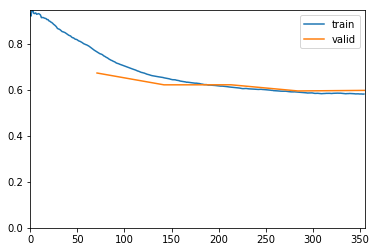

Better model found at epoch 0 with val_loss value: 0.6733449101448059.
Better model found at epoch 1 with val_loss value: 0.6219168901443481.
Better model found at epoch 3 with val_loss value: 0.5953028202056885.


In [39]:
learn.fit_one_cycle(5,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [40]:
learn.save('resnet34-stage-1')

In [21]:
learn.load('resnet34-stage-1');

In [41]:
learn.purge()
learn.unfreeze()

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


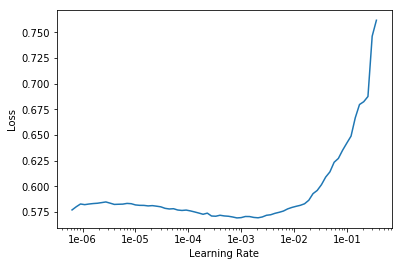

In [43]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
1,0.578047,0.588865,0.314670,0.685330,14:43
2,0.566004,0.573437,0.297466,0.702534,16:19
3,0.552305,0.558046,0.283703,0.716297,16:15
4,0.542241,0.556961,0.284016,0.715984,16:14
5,0.537519,0.553843,0.283703,0.716297,16:13


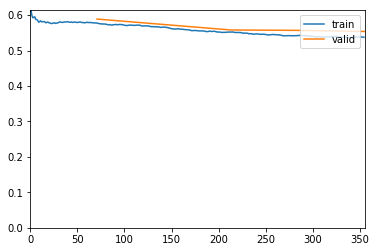

Better model found at epoch 1 with val_loss value: 0.5888653993606567.
Better model found at epoch 2 with val_loss value: 0.5734368562698364.
Better model found at epoch 3 with val_loss value: 0.5580459237098694.
Better model found at epoch 4 with val_loss value: 0.5569610595703125.
Better model found at epoch 5 with val_loss value: 0.5538430213928223.


In [25]:
lr=1e-4
learn.fit_one_cycle(5,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.576275,0.590239,0.319049,0.680951,01:24
1,0.564980,0.572742,0.298405,0.701595,01:25
2,0.551877,0.564305,0.291211,0.708789,01:25
3,0.543682,0.561075,0.286831,0.713169,01:26
4,0.537840,0.559501,0.285580,0.714420,01:25


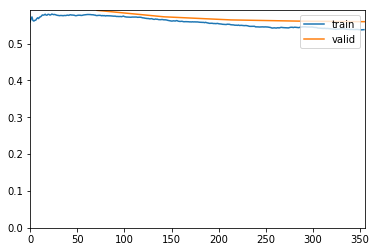

Better model found at epoch 0 with val_loss value: 0.5902385711669922.
Better model found at epoch 1 with val_loss value: 0.5727419257164001.
Better model found at epoch 2 with val_loss value: 0.5643052458763123.
Better model found at epoch 3 with val_loss value: 0.5610751509666443.
Better model found at epoch 4 with val_loss value: 0.5595011115074158.


In [44]:
lr=1e-4
learn.fit_one_cycle(5,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [45]:
learn.save('resnet34-stage-2')

#### Results by image

In [95]:
size = 112
bs = 512

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs, 
                                  ).normalize(imagenet_stats)

In [96]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], wd=0.1)

In [97]:
learn.load('resnet34-stage-2');

In [98]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

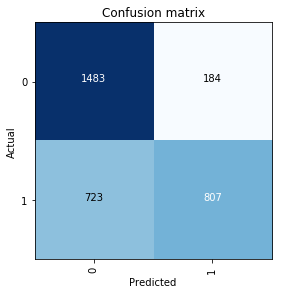

In [99]:
# first interpretation
interp.plot_confusion_matrix()

In [100]:
interp.most_confused(min_val=2)

[('1', '0', 723), ('0', '1', 184)]

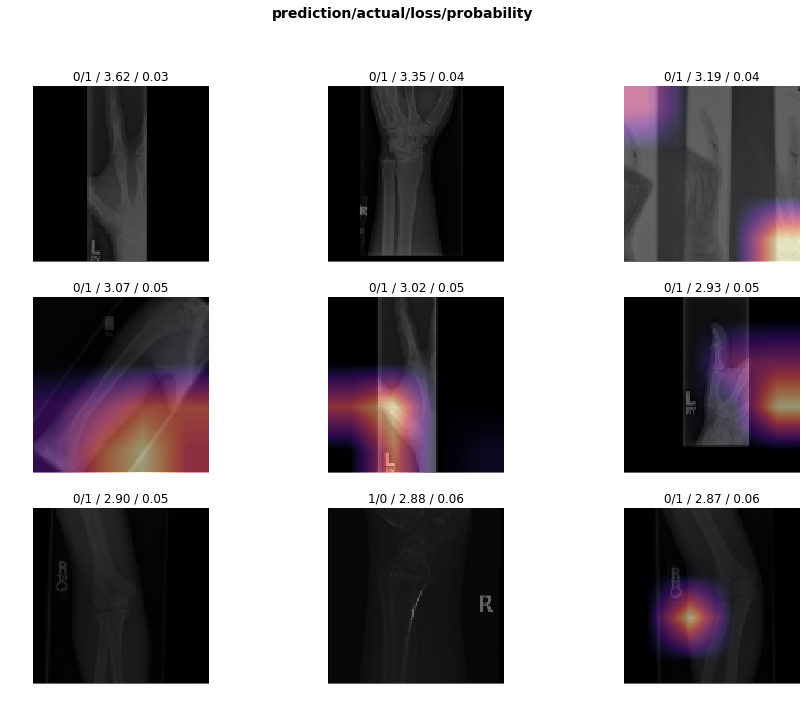

In [101]:
interp.plot_top_losses(9, figsize=(15,11))

#### Results by study

In [102]:
learn.load('resnet34-stage-2');

In [103]:
# validation
preds_val, y_val = learn.get_preds()

In [104]:
preds_val

tensor([[0.2962, 0.7038],
        [0.1308, 0.8692],
        [0.4768, 0.5232],
        ...,
        [0.7501, 0.2499],
        [0.8186, 0.1814],
        [0.6868, 0.3132]])

In [105]:
len(preds_val)

3197

In [106]:
for img_url in data.valid_ds.x.items:
    print(img_url)
    break

/home/jupyter/tutorials/data/MURA-v1.1/data2/valid/1/HAND_patient11538_study1_positive_image1.png


In [107]:
pat_label = re.compile(r'/([^/]+)_patient[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^_]+.png$')

In [108]:
%%time
studies = dict()
studies_num = dict()
labels_num = dict()

for m in mura:
    labels_num[m] = 0

for idx, src in enumerate(data.valid_ds.x.items):
    # get label name
    label = pat_label.search(str(src))
    label = label.group(1) 
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1) 
    # sum probabilities by study
    if study in studies:
        studies[study] += preds_val[idx,:].clone()
        studies_num[study] += 1
    else:
        studies[study] = preds_val[idx,:].clone()
        studies_num[study] = 1
    labels[study] = label

CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 50.2 ms


In [109]:
labels

{'HAND_patient11538_study1_positive': 'HAND',
 'FINGER_patient11480_study1_positive': 'FINGER',
 'ELBOW_patient11756_study1_positive': 'ELBOW',
 'ELBOW_patient11817_study1_positive': 'ELBOW',
 'WRIST_patient11206_study1_positive': 'WRIST',
 'HAND_patient11518_study1_positive': 'HAND',
 'ELBOW_patient11421_study1_positive': 'ELBOW',
 'SHOULDER_patient11707_study1_positive': 'SHOULDER',
 'FINGER_patient11910_study1_positive': 'FINGER',
 'FOREARM_patient11319_study1_positive': 'FOREARM',
 'HUMERUS_patient11645_study1_positive': 'HUMERUS',
 'SHOULDER_patient11245_study1_positive': 'SHOULDER',
 'SHOULDER_patient11549_study1_positive': 'SHOULDER',
 'HUMERUS_patient11608_study1_positive': 'HUMERUS',
 'FOREARM_patient11420_study1_positive': 'FOREARM',
 'HAND_patient11504_study1_positive': 'HAND',
 'WRIST_patient11225_study1_positive': 'WRIST',
 'FOREARM_patient11428_study1_positive': 'FOREARM',
 'SHOULDER_patient11735_study1_positive': 'SHOULDER',
 'SHOULDER_patient11738_study1_positive': 'SHO

In [110]:
labels_num = dict()
for m in mura:
    labels_num[m] = sum([1 for k,v in labels.items() if v.lower() == m])

In [111]:
print(labels_num)
print(sum([v for k,v in labels_num.items()]))

{'elbow': 158, 'finger': 175, 'forearm': 133, 'hand': 167, 'humerus': 135, 'shoulder': 194, 'wrist': 237}
1199


In [112]:
studies

{'HAND_patient11538_study1_positive': tensor([0.6013, 1.3987]),
 'FINGER_patient11480_study1_positive': tensor([0.3893, 1.6107]),
 'ELBOW_patient11756_study1_positive': tensor([0.9015, 3.0985]),
 'ELBOW_patient11817_study1_positive': tensor([3.2003, 1.7997]),
 'WRIST_patient11206_study1_positive': tensor([0.6182, 2.3818]),
 'HAND_patient11518_study1_positive': tensor([1.5353, 0.4647]),
 'ELBOW_patient11421_study1_positive': tensor([2.2024, 1.7976]),
 'SHOULDER_patient11707_study1_positive': tensor([2.8271, 2.1729]),
 'FINGER_patient11910_study1_positive': tensor([2.7501, 2.2499]),
 'FOREARM_patient11319_study1_positive': tensor([0.4933, 1.5067]),
 'HUMERUS_patient11645_study1_positive': tensor([0.5436, 1.4564]),
 'SHOULDER_patient11245_study1_positive': tensor([0.8432, 0.1568]),
 'SHOULDER_patient11549_study1_positive': tensor([1.0621, 2.9379]),
 'HUMERUS_patient11608_study1_positive': tensor([1.1964, 0.8036]),
 'FOREARM_patient11420_study1_positive': tensor([2.8566, 1.1434]),
 'HAND_p

In [113]:
len(studies)

1199

In [114]:
studies_num

{'HAND_patient11538_study1_positive': 2,
 'FINGER_patient11480_study1_positive': 2,
 'ELBOW_patient11756_study1_positive': 4,
 'ELBOW_patient11817_study1_positive': 5,
 'WRIST_patient11206_study1_positive': 3,
 'HAND_patient11518_study1_positive': 2,
 'ELBOW_patient11421_study1_positive': 4,
 'SHOULDER_patient11707_study1_positive': 5,
 'FINGER_patient11910_study1_positive': 5,
 'FOREARM_patient11319_study1_positive': 2,
 'HUMERUS_patient11645_study1_positive': 2,
 'SHOULDER_patient11245_study1_positive': 1,
 'SHOULDER_patient11549_study1_positive': 4,
 'HUMERUS_patient11608_study1_positive': 2,
 'FOREARM_patient11420_study1_positive': 4,
 'HAND_patient11504_study1_positive': 2,
 'WRIST_patient11225_study1_positive': 3,
 'FOREARM_patient11428_study1_positive': 2,
 'SHOULDER_patient11735_study1_positive': 4,
 'SHOULDER_patient11738_study1_positive': 4,
 'ELBOW_patient11603_study1_positive': 2,
 'WRIST_patient11216_study1_positive': 5,
 'HAND_patient11502_study1_positive': 4,
 'WRIST_pat

In [115]:
len(studies_num)

1199

In [116]:
# get averages
for (k,v) in studies.items():
    studies[k] = studies[k] / studies_num[k]

In [117]:
studies

{'HAND_patient11538_study1_positive': tensor([0.3007, 0.6993]),
 'FINGER_patient11480_study1_positive': tensor([0.1946, 0.8054]),
 'ELBOW_patient11756_study1_positive': tensor([0.2254, 0.7746]),
 'ELBOW_patient11817_study1_positive': tensor([0.6401, 0.3599]),
 'WRIST_patient11206_study1_positive': tensor([0.2061, 0.7939]),
 'HAND_patient11518_study1_positive': tensor([0.7677, 0.2323]),
 'ELBOW_patient11421_study1_positive': tensor([0.5506, 0.4494]),
 'SHOULDER_patient11707_study1_positive': tensor([0.5654, 0.4346]),
 'FINGER_patient11910_study1_positive': tensor([0.5500, 0.4500]),
 'FOREARM_patient11319_study1_positive': tensor([0.2467, 0.7533]),
 'HUMERUS_patient11645_study1_positive': tensor([0.2718, 0.7282]),
 'SHOULDER_patient11245_study1_positive': tensor([0.8432, 0.1568]),
 'SHOULDER_patient11549_study1_positive': tensor([0.2655, 0.7345]),
 'HUMERUS_patient11608_study1_positive': tensor([0.5982, 0.4018]),
 'FOREARM_patient11420_study1_positive': tensor([0.7142, 0.2858]),
 'HAND_p

In [118]:
# get predictions by study
acc = 0.
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    if 'negative' in k:
        acc += (0 == y_hat.item())
    else:
        acc += (1 == y_hat.item())
    # print(f'{k} {y_hat.item()} ({prob})')

In [119]:
len(studies), acc

(1199, 876.0)

In [120]:
# get study accuracy total
print(f'study accuracy total: {round(acc / len(studies),3)}')

study accuracy total: 0.731


In [121]:
# get predictions by study and label
acc_label = dict()
for m in mura:
    acc_label[m] = 0
    
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    label = labels[k]
    if 'negative' in k:
        acc_label[label.lower()] += (0 == y_hat.item())
    else:
        acc_label[label.lower()] += (1 == y_hat.item())

In [122]:
acc_label

{'elbow': 120,
 'finger': 121,
 'forearm': 105,
 'hand': 112,
 'humerus': 102,
 'shoulder': 130,
 'wrist': 186}

In [123]:
sum([v for k,v in acc_label.items()])

876

In [124]:
labels_num

{'elbow': 158,
 'finger': 175,
 'forearm': 133,
 'hand': 167,
 'humerus': 135,
 'shoulder': 194,
 'wrist': 237}

In [125]:
# get study accuracy by label
for m in mura:
    print(f'{m}: {round(acc_label[m] / labels_num[m],3)}')

elbow: 0.759
finger: 0.691
forearm: 0.789
hand: 0.671
humerus: 0.756
shoulder: 0.67
wrist: 0.785


### size = 224

In [149]:
learn = None
gc.collect()

7046

In [150]:
torch.cuda.empty_cache()

In [151]:
size = 224
bs = 128

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs, 
                                  ).normalize(imagenet_stats)

In [152]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], wd=0.1)

In [153]:
learn.load('resnet34-stage-2');

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.543209,0.529940,0.258993,0.741007,02:43
1,0.511583,0.511662,0.243666,0.756334,02:43
2,0.497246,0.504433,0.238661,0.761339,02:43
3,0.480150,0.498858,0.236472,0.763528,02:43
4,0.473954,0.486756,0.229590,0.770410,02:43


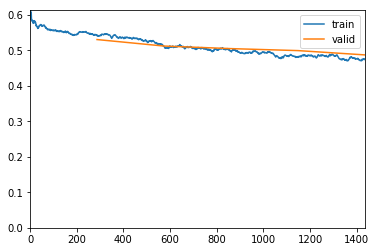

Better model found at epoch 0 with val_loss value: 0.5299397706985474.
Better model found at epoch 1 with val_loss value: 0.5116621851921082.
Better model found at epoch 2 with val_loss value: 0.5044328570365906.
Better model found at epoch 3 with val_loss value: 0.4988577663898468.
Better model found at epoch 4 with val_loss value: 0.4867563545703888.


In [154]:
learn.fit_one_cycle(5,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [155]:
learn.save('resnet34-stage-3');

In [156]:
learn = None
gc.collect()
torch.cuda.empty_cache()

In [157]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], wd=0.1)
learn.load('resnet34-stage-3');

In [158]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


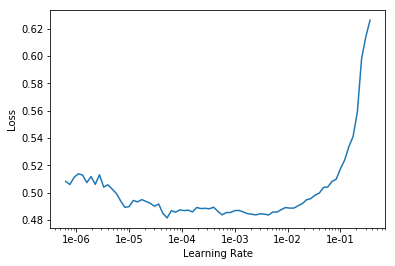

In [159]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.480293,0.487448,0.228026,0.771974,02:41
1,0.474168,0.482256,0.222709,0.777291,02:42
2,0.468879,0.483917,0.227401,0.772599,02:44
3,0.461243,0.477690,0.223334,0.776666,02:43
4,0.468197,0.475864,0.221145,0.778855,02:43


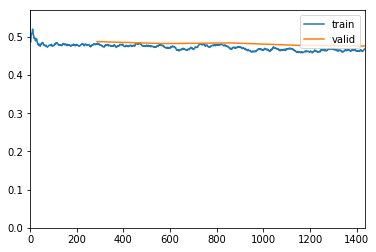

Better model found at epoch 0 with val_loss value: 0.4874477982521057.
Better model found at epoch 1 with val_loss value: 0.4822562336921692.
Better model found at epoch 3 with val_loss value: 0.47769007086753845.
Better model found at epoch 4 with val_loss value: 0.47586414217948914.


In [160]:
lr = 3e-4
learn.fit_one_cycle(5,max_lr=lr,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [161]:
learn.save('resnet34-stage-4')

In [36]:
learn.load('resnet34-stage-4');

In [162]:
learn.purge()
learn.unfreeze()

In [163]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


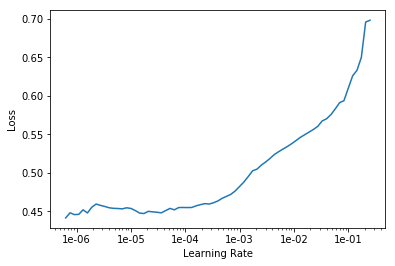

In [164]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.467906,0.474374,0.221458,0.778542,03:37
1,0.464342,0.472145,0.219581,0.780419,03:39
2,0.466083,0.478271,0.222709,0.777291,03:38
3,0.460885,0.479489,0.223960,0.776040,03:39
4,0.460538,0.474725,0.221770,0.778230,03:39


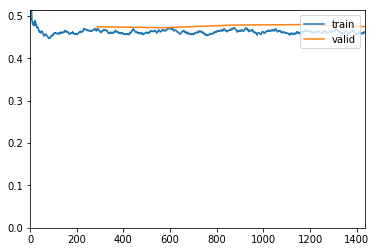

Better model found at epoch 0 with val_loss value: 0.47437402606010437.
Better model found at epoch 1 with val_loss value: 0.47214457392692566.


In [165]:
lr=3e-6
learn.fit_one_cycle(5,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [166]:
learn.save('resnet34-stage-5')

#### Results by image

In [167]:
size = 224
bs = 128

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs, 
                                  ).normalize(imagenet_stats)

In [168]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], wd=0.1)

In [169]:
learn.load('resnet34-stage-5');

In [170]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

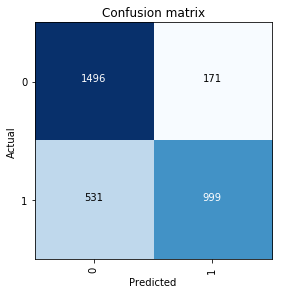

In [171]:
# first interpretation
interp.plot_confusion_matrix()

In [172]:
interp.most_confused(min_val=2)

[('1', '0', 531), ('0', '1', 171)]

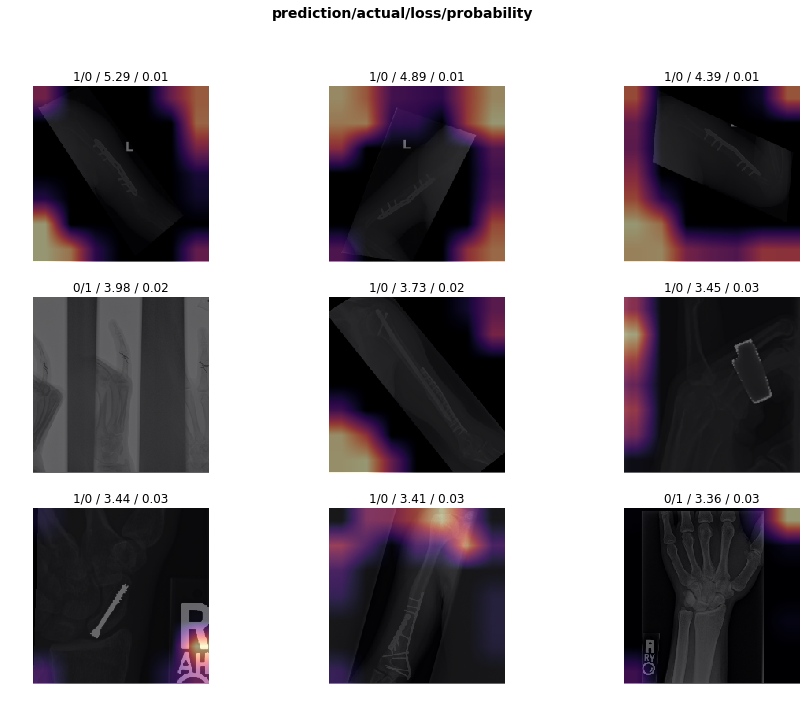

In [173]:
interp.plot_top_losses(9, figsize=(15,11))

#### Results by study

In [174]:
learn.load('resnet34-stage-5');

In [175]:
# validation
preds_val, y_val = learn.get_preds()

In [176]:
preds_val

tensor([[0.0743, 0.9257],
        [0.0709, 0.9291],
        [0.1770, 0.8230],
        ...,
        [0.8040, 0.1960],
        [0.8942, 0.1058],
        [0.6382, 0.3618]])

In [177]:
len(preds_val)

3197

In [178]:
for img_url in data.valid_ds.x.items:
    print(img_url)
    break

/home/jupyter/tutorials/data/MURA-v1.1/data2/valid/1/HAND_patient11538_study1_positive_image1.png


In [179]:
pat_label = re.compile(r'/([^/]+)_patient[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^_]+.png$')

In [180]:
%%time
studies = dict()
studies_num = dict()
labels_num = dict()

for m in mura:
    labels_num[m] = 0

for idx, src in enumerate(data.valid_ds.x.items):
    # get label name
    label = pat_label.search(str(src))
    label = label.group(1) 
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1) 
    # sum probabilities by study
    if study in studies:
        studies[study] += preds_val[idx,:].clone()
        studies_num[study] += 1
    else:
        studies[study] = preds_val[idx,:].clone()
        studies_num[study] = 1
    labels[study] = label

CPU times: user 208 ms, sys: 0 ns, total: 208 ms
Wall time: 49.5 ms


In [181]:
labels

{'HAND_patient11538_study1_positive': 'HAND',
 'FINGER_patient11480_study1_positive': 'FINGER',
 'ELBOW_patient11756_study1_positive': 'ELBOW',
 'ELBOW_patient11817_study1_positive': 'ELBOW',
 'WRIST_patient11206_study1_positive': 'WRIST',
 'HAND_patient11518_study1_positive': 'HAND',
 'ELBOW_patient11421_study1_positive': 'ELBOW',
 'SHOULDER_patient11707_study1_positive': 'SHOULDER',
 'FINGER_patient11910_study1_positive': 'FINGER',
 'FOREARM_patient11319_study1_positive': 'FOREARM',
 'HUMERUS_patient11645_study1_positive': 'HUMERUS',
 'SHOULDER_patient11245_study1_positive': 'SHOULDER',
 'SHOULDER_patient11549_study1_positive': 'SHOULDER',
 'HUMERUS_patient11608_study1_positive': 'HUMERUS',
 'FOREARM_patient11420_study1_positive': 'FOREARM',
 'HAND_patient11504_study1_positive': 'HAND',
 'WRIST_patient11225_study1_positive': 'WRIST',
 'FOREARM_patient11428_study1_positive': 'FOREARM',
 'SHOULDER_patient11735_study1_positive': 'SHOULDER',
 'SHOULDER_patient11738_study1_positive': 'SHO

In [182]:
labels_num = dict()
for m in mura:
    labels_num[m] = sum([1 for k,v in labels.items() if v.lower() == m])

In [183]:
print(labels_num)
print(sum([v for k,v in labels_num.items()]))

{'elbow': 158, 'finger': 175, 'forearm': 133, 'hand': 167, 'humerus': 135, 'shoulder': 194, 'wrist': 237}
1199


In [184]:
studies

{'HAND_patient11538_study1_positive': tensor([0.5051, 1.4949]),
 'FINGER_patient11480_study1_positive': tensor([0.1070, 1.8930]),
 'ELBOW_patient11756_study1_positive': tensor([0.2377, 3.7623]),
 'ELBOW_patient11817_study1_positive': tensor([2.9307, 2.0693]),
 'WRIST_patient11206_study1_positive': tensor([0.1006, 2.8994]),
 'HAND_patient11518_study1_positive': tensor([1.6528, 0.3472]),
 'ELBOW_patient11421_study1_positive': tensor([1.5805, 2.4195]),
 'SHOULDER_patient11707_study1_positive': tensor([3.2534, 1.7466]),
 'FINGER_patient11910_study1_positive': tensor([1.2216, 3.7784]),
 'FOREARM_patient11319_study1_positive': tensor([0.0647, 1.9353]),
 'HUMERUS_patient11645_study1_positive': tensor([0.0456, 1.9544]),
 'SHOULDER_patient11245_study1_positive': tensor([0.6171, 0.3829]),
 'SHOULDER_patient11549_study1_positive': tensor([0.3833, 3.6167]),
 'HUMERUS_patient11608_study1_positive': tensor([1.0268, 0.9732]),
 'FOREARM_patient11420_study1_positive': tensor([2.7690, 1.2310]),
 'HAND_p

In [185]:
len(studies)

1199

In [186]:
studies_num

{'HAND_patient11538_study1_positive': 2,
 'FINGER_patient11480_study1_positive': 2,
 'ELBOW_patient11756_study1_positive': 4,
 'ELBOW_patient11817_study1_positive': 5,
 'WRIST_patient11206_study1_positive': 3,
 'HAND_patient11518_study1_positive': 2,
 'ELBOW_patient11421_study1_positive': 4,
 'SHOULDER_patient11707_study1_positive': 5,
 'FINGER_patient11910_study1_positive': 5,
 'FOREARM_patient11319_study1_positive': 2,
 'HUMERUS_patient11645_study1_positive': 2,
 'SHOULDER_patient11245_study1_positive': 1,
 'SHOULDER_patient11549_study1_positive': 4,
 'HUMERUS_patient11608_study1_positive': 2,
 'FOREARM_patient11420_study1_positive': 4,
 'HAND_patient11504_study1_positive': 2,
 'WRIST_patient11225_study1_positive': 3,
 'FOREARM_patient11428_study1_positive': 2,
 'SHOULDER_patient11735_study1_positive': 4,
 'SHOULDER_patient11738_study1_positive': 4,
 'ELBOW_patient11603_study1_positive': 2,
 'WRIST_patient11216_study1_positive': 5,
 'HAND_patient11502_study1_positive': 4,
 'WRIST_pat

In [187]:
len(studies_num)

1199

In [188]:
# get averages
for (k,v) in studies.items():
    studies[k] = studies[k] / studies_num[k]

In [189]:
studies

{'HAND_patient11538_study1_positive': tensor([0.2526, 0.7474]),
 'FINGER_patient11480_study1_positive': tensor([0.0535, 0.9465]),
 'ELBOW_patient11756_study1_positive': tensor([0.0594, 0.9406]),
 'ELBOW_patient11817_study1_positive': tensor([0.5861, 0.4139]),
 'WRIST_patient11206_study1_positive': tensor([0.0335, 0.9665]),
 'HAND_patient11518_study1_positive': tensor([0.8264, 0.1736]),
 'ELBOW_patient11421_study1_positive': tensor([0.3951, 0.6049]),
 'SHOULDER_patient11707_study1_positive': tensor([0.6507, 0.3493]),
 'FINGER_patient11910_study1_positive': tensor([0.2443, 0.7557]),
 'FOREARM_patient11319_study1_positive': tensor([0.0323, 0.9677]),
 'HUMERUS_patient11645_study1_positive': tensor([0.0228, 0.9772]),
 'SHOULDER_patient11245_study1_positive': tensor([0.6171, 0.3829]),
 'SHOULDER_patient11549_study1_positive': tensor([0.0958, 0.9042]),
 'HUMERUS_patient11608_study1_positive': tensor([0.5134, 0.4866]),
 'FOREARM_patient11420_study1_positive': tensor([0.6923, 0.3077]),
 'HAND_p

In [190]:
# get predictions by study
acc = 0.
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    if 'negative' in k:
        acc += (0 == y_hat.item())
    else:
        acc += (1 == y_hat.item())
    # print(f'{k} {y_hat.item()} ({prob})')

In [191]:
len(studies), acc

(1199, 955.0)

In [192]:
# get study accuracy total
print(f'study accuracy total: {round(acc / len(studies),3)}')

study accuracy total: 0.796


In [193]:
# get predictions by study and label
acc_label = dict()
for m in mura:
    acc_label[m] = 0
    
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    label = labels[k]
    if 'negative' in k:
        acc_label[label.lower()] += (0 == y_hat.item())
    else:
        acc_label[label.lower()] += (1 == y_hat.item())

In [194]:
acc_label

{'elbow': 129,
 'finger': 132,
 'forearm': 113,
 'hand': 124,
 'humerus': 110,
 'shoulder': 148,
 'wrist': 199}

In [195]:
sum([v for k,v in acc_label.items()])

955

In [196]:
labels_num

{'elbow': 158,
 'finger': 175,
 'forearm': 133,
 'hand': 167,
 'humerus': 135,
 'shoulder': 194,
 'wrist': 237}

In [197]:
# get study accuracy by label
for m in mura:
    print(f'{m}: {round(acc_label[m] / labels_num[m],3)}')

elbow: 0.816
finger: 0.754
forearm: 0.85
hand: 0.743
humerus: 0.815
shoulder: 0.763
wrist: 0.84


## Training with densenet169

###  size = 112

In [29]:
import gc
import torch

In [30]:
learn = None
gc.collect()

16898

In [31]:
torch.cuda.empty_cache()

In [62]:
size = 112
bs = 256

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs, 
                                  ).normalize(imagenet_stats)

In [63]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], wd=0.1)
learn = learn.to_fp16()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.647629,0.605026,0.325931,0.674069,01:56
1,0.553631,0.549180,0.288395,0.711605,01:45
2,0.523585,0.512760,0.249922,0.750078,01:44
3,0.503554,0.505001,0.247732,0.752268,01:44
4,0.486226,0.510447,0.249922,0.750078,01:44


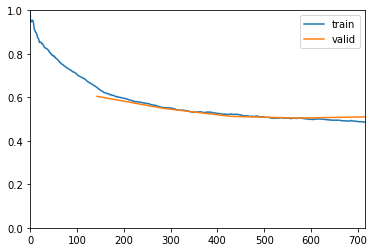

Better model found at epoch 0 with val_loss value: 0.6050257086753845.
Better model found at epoch 1 with val_loss value: 0.549180269241333.
Better model found at epoch 2 with val_loss value: 0.5127597451210022.
Better model found at epoch 3 with val_loss value: 0.5050009489059448.


In [64]:
learn.fit_one_cycle(5,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [65]:
learn.save('densenet169-stage-1')

In [66]:
learn.load('densenet169-stage-1');
learn = learn.to_fp16()

In [67]:
learn.purge()
learn.unfreeze()

In [68]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


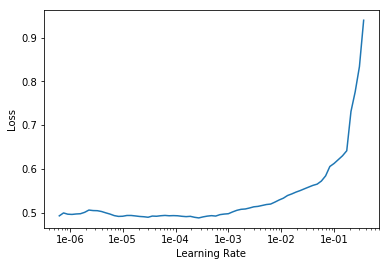

In [69]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.492801,0.509401,0.248983,0.751017,02:07
1,0.487105,0.498616,0.239600,0.760400,02:07
2,0.485631,0.496530,0.237723,0.762277,02:07
3,0.476899,0.494938,0.233969,0.766031,02:07
4,0.476169,0.492549,0.233344,0.766656,02:06


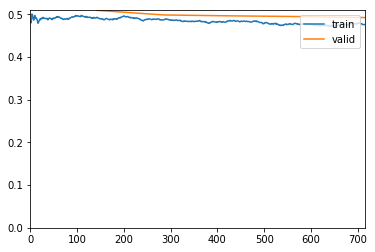

Better model found at epoch 0 with val_loss value: 0.5094006061553955.
Better model found at epoch 1 with val_loss value: 0.4986157715320587.
Better model found at epoch 2 with val_loss value: 0.4965299963951111.
Better model found at epoch 3 with val_loss value: 0.49493834376335144.
Better model found at epoch 4 with val_loss value: 0.49254900217056274.


In [70]:
lr=1e-4
learn.fit_one_cycle(5,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [71]:
learn.save('densenet169-stage-2')

#### Results by image

In [72]:
size = 112
bs = 256

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs, 
                                  ).normalize(imagenet_stats)

In [73]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], wd=0.1)

In [74]:
learn.load('densenet169-stage-2');

In [75]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

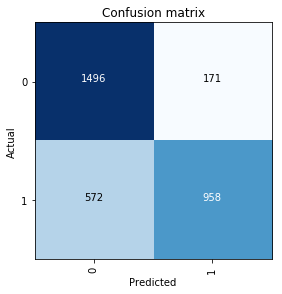

In [76]:
# first interpretation
interp.plot_confusion_matrix()

In [77]:
interp.most_confused(min_val=2)

[('1', '0', 572), ('0', '1', 171)]

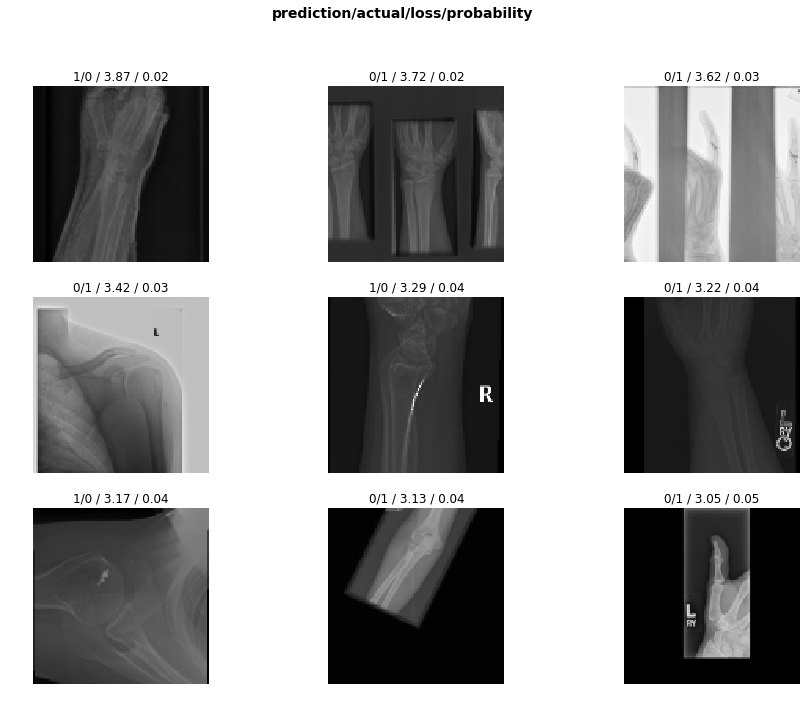

In [78]:
interp.plot_top_losses(9, figsize=(15,11))

#### Results by study

In [140]:
learn.load('densenet169-stage-2');

In [141]:
# validation
preds_val, y_val = learn.get_preds()

In [142]:
preds_val

tensor([[0.4870, 0.5130],
        [0.1144, 0.8856],
        [0.3515, 0.6485],
        ...,
        [0.7868, 0.2132],
        [0.8687, 0.1313],
        [0.8325, 0.1675]])

In [143]:
len(preds_val)

3197

In [144]:
for img_url in data.valid_ds.x.items:
    print(img_url)
    break

/home/jupyter/tutorials/data/MURA-v1.1/data2/valid/1/HAND_patient11538_study1_positive_image1.png


In [145]:
pat_label = re.compile(r'/([^/]+)_patient[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^_]+.png$')

In [157]:
%%time
studies = dict()
studies_num = dict()
labels = dict()

for m in mura:
    labels_num[m] = 0

for idx, src in enumerate(data.valid_ds.x.items):
    # get label name
    label = pat_label.search(str(src))
    label = label.group(1) 
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1) 
    # sum probabilities by study
    if study in studies:
        studies[study] += preds_val[idx,:].clone()
        studies_num[study] += 1
    else:
        studies[study] = preds_val[idx,:].clone()
        studies_num[study] = 1
    labels[study] = label

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 43.7 ms


In [158]:
labels

{'HAND_patient11538_study1_positive': 'HAND',
 'FINGER_patient11480_study1_positive': 'FINGER',
 'ELBOW_patient11756_study1_positive': 'ELBOW',
 'ELBOW_patient11817_study1_positive': 'ELBOW',
 'WRIST_patient11206_study1_positive': 'WRIST',
 'HAND_patient11518_study1_positive': 'HAND',
 'ELBOW_patient11421_study1_positive': 'ELBOW',
 'SHOULDER_patient11707_study1_positive': 'SHOULDER',
 'FINGER_patient11910_study1_positive': 'FINGER',
 'FOREARM_patient11319_study1_positive': 'FOREARM',
 'HUMERUS_patient11645_study1_positive': 'HUMERUS',
 'SHOULDER_patient11245_study1_positive': 'SHOULDER',
 'SHOULDER_patient11549_study1_positive': 'SHOULDER',
 'HUMERUS_patient11608_study1_positive': 'HUMERUS',
 'FOREARM_patient11420_study1_positive': 'FOREARM',
 'HAND_patient11504_study1_positive': 'HAND',
 'WRIST_patient11225_study1_positive': 'WRIST',
 'FOREARM_patient11428_study1_positive': 'FOREARM',
 'SHOULDER_patient11735_study1_positive': 'SHOULDER',
 'SHOULDER_patient11738_study1_positive': 'SHO

In [162]:
labels_num = dict()
for m in mura:
    labels_num[m] = sum([1 for k,v in labels.items() if v.lower() == m])

In [167]:
print(labels_num)
print(sum([v for k,v in labels_num.items()]))

{'elbow': 158, 'finger': 175, 'forearm': 133, 'hand': 167, 'humerus': 135, 'shoulder': 194, 'wrist': 237}
1199


In [168]:
studies

{'HAND_patient11538_study1_positive': tensor([0.9642, 1.0358]),
 'FINGER_patient11480_study1_positive': tensor([0.1972, 1.8028]),
 'ELBOW_patient11756_study1_positive': tensor([0.4948, 3.5052]),
 'ELBOW_patient11817_study1_positive': tensor([3.3944, 1.6056]),
 'WRIST_patient11206_study1_positive': tensor([0.4539, 2.5461]),
 'HAND_patient11518_study1_positive': tensor([1.2339, 0.7661]),
 'ELBOW_patient11421_study1_positive': tensor([2.1247, 1.8753]),
 'SHOULDER_patient11707_study1_positive': tensor([3.1845, 1.8155]),
 'FINGER_patient11910_study1_positive': tensor([2.0216, 2.9784]),
 'FOREARM_patient11319_study1_positive': tensor([0.1551, 1.8449]),
 'HUMERUS_patient11645_study1_positive': tensor([0.0837, 1.9163]),
 'SHOULDER_patient11245_study1_positive': tensor([0.7488, 0.2512]),
 'SHOULDER_patient11549_study1_positive': tensor([0.3205, 3.6795]),
 'HUMERUS_patient11608_study1_positive': tensor([1.2323, 0.7677]),
 'FOREARM_patient11420_study1_positive': tensor([2.6874, 1.3126]),
 'HAND_p

In [170]:
len(studies)

1199

In [169]:
studies_num

{'HAND_patient11538_study1_positive': 2,
 'FINGER_patient11480_study1_positive': 2,
 'ELBOW_patient11756_study1_positive': 4,
 'ELBOW_patient11817_study1_positive': 5,
 'WRIST_patient11206_study1_positive': 3,
 'HAND_patient11518_study1_positive': 2,
 'ELBOW_patient11421_study1_positive': 4,
 'SHOULDER_patient11707_study1_positive': 5,
 'FINGER_patient11910_study1_positive': 5,
 'FOREARM_patient11319_study1_positive': 2,
 'HUMERUS_patient11645_study1_positive': 2,
 'SHOULDER_patient11245_study1_positive': 1,
 'SHOULDER_patient11549_study1_positive': 4,
 'HUMERUS_patient11608_study1_positive': 2,
 'FOREARM_patient11420_study1_positive': 4,
 'HAND_patient11504_study1_positive': 2,
 'WRIST_patient11225_study1_positive': 3,
 'FOREARM_patient11428_study1_positive': 2,
 'SHOULDER_patient11735_study1_positive': 4,
 'SHOULDER_patient11738_study1_positive': 4,
 'ELBOW_patient11603_study1_positive': 2,
 'WRIST_patient11216_study1_positive': 5,
 'HAND_patient11502_study1_positive': 4,
 'WRIST_pat

In [172]:
len(studies_num)

1199

In [173]:
# get averages
for (k,v) in studies.items():
    studies[k] = studies[k] / studies_num[k]

In [174]:
studies

{'HAND_patient11538_study1_positive': tensor([0.4821, 0.5179]),
 'FINGER_patient11480_study1_positive': tensor([0.0986, 0.9014]),
 'ELBOW_patient11756_study1_positive': tensor([0.1237, 0.8763]),
 'ELBOW_patient11817_study1_positive': tensor([0.6789, 0.3211]),
 'WRIST_patient11206_study1_positive': tensor([0.1513, 0.8487]),
 'HAND_patient11518_study1_positive': tensor([0.6170, 0.3830]),
 'ELBOW_patient11421_study1_positive': tensor([0.5312, 0.4688]),
 'SHOULDER_patient11707_study1_positive': tensor([0.6369, 0.3631]),
 'FINGER_patient11910_study1_positive': tensor([0.4043, 0.5957]),
 'FOREARM_patient11319_study1_positive': tensor([0.0775, 0.9225]),
 'HUMERUS_patient11645_study1_positive': tensor([0.0419, 0.9581]),
 'SHOULDER_patient11245_study1_positive': tensor([0.7488, 0.2512]),
 'SHOULDER_patient11549_study1_positive': tensor([0.0801, 0.9199]),
 'HUMERUS_patient11608_study1_positive': tensor([0.6162, 0.3838]),
 'FOREARM_patient11420_study1_positive': tensor([0.6719, 0.3281]),
 'HAND_p

In [175]:
# get predictions by study
acc = 0.
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    if 'negative' in k:
        acc += (0 == y_hat.item())
    else:
        acc += (1 == y_hat.item())
    # print(f'{k} {y_hat.item()} ({prob})')

In [176]:
len(studies), acc

(1199, 942.0)

In [177]:
# get study accuracy total
print(f'study accuracy total: {round(acc / len(studies),3)}')

study accuracy total: 0.786


In [178]:
# get predictions by study and label
acc_label = dict()
for m in mura:
    acc_label[m] = 0
    
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    label = labels[k]
    if 'negative' in k:
        acc_label[label.lower()] += (0 == y_hat.item())
    else:
        acc_label[label.lower()] += (1 == y_hat.item())

In [179]:
acc_label

{'elbow': 131,
 'finger': 127,
 'forearm': 110,
 'hand': 119,
 'humerus': 113,
 'shoulder': 148,
 'wrist': 194}

In [180]:
sum([v for k,v in acc_label.items()])

942

In [181]:
labels_num

{'elbow': 158,
 'finger': 175,
 'forearm': 133,
 'hand': 167,
 'humerus': 135,
 'shoulder': 194,
 'wrist': 237}

In [185]:
# get study accuracy by label
for m in mura:
    print(f'{m}: {round(acc_label[m] / labels_num[m],3)}')

elbow: 0.829
finger: 0.726
forearm: 0.827
hand: 0.713
humerus: 0.837
shoulder: 0.763
wrist: 0.819


### size = 224

In [186]:
import gc
import torch

In [187]:
learn = None
gc.collect()

0

In [32]:
torch.cuda.empty_cache()

In [33]:
size = 224
bs = 64

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs,
                                  ).normalize(imagenet_stats)

In [34]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], wd=0.1).to_fp16()
learn.load('densenet169-stage-2');

In [191]:
learn.purge()
learn.freeze()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.490027,0.488455,0.223334,0.776666,05:57
1,0.471393,0.471150,0.214576,0.785424,05:49
2,0.455348,0.482685,0.221770,0.778230,05:48
3,0.451842,0.469388,0.200188,0.799812,05:48
4,0.436706,0.436651,0.187989,0.812011,05:47
5,0.418453,0.426457,0.186425,0.813575,05:49
6,0.410162,0.422927,0.180482,0.819518,05:48
7,0.407144,0.428222,0.181733,0.818267,05:48
8,0.406907,0.417924,0.182358,0.817642,05:48
9,0.389888,0.419074,0.184861,0.815139,05:47


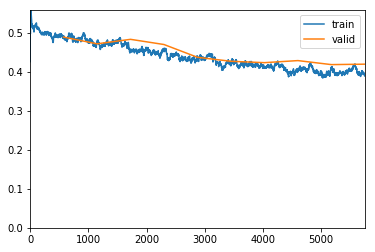

Better model found at epoch 0 with val_loss value: 0.4884549379348755.
Better model found at epoch 1 with val_loss value: 0.4711495637893677.
Better model found at epoch 3 with val_loss value: 0.46938833594322205.
Better model found at epoch 4 with val_loss value: 0.43665093183517456.
Better model found at epoch 5 with val_loss value: 0.42645740509033203.
Better model found at epoch 6 with val_loss value: 0.4229273200035095.
Better model found at epoch 8 with val_loss value: 0.41792407631874084.


In [192]:
learn.fit_one_cycle(10,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [193]:
learn.save('densenet169-stage-3')

In [194]:
learn = None
gc.collect()
torch.cuda.empty_cache()

In [35]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], wd=0.1).to_fp16()
learn.load('densenet169-stage-3');

In [196]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


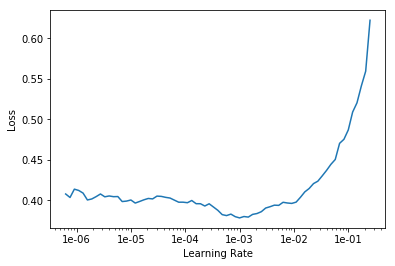

In [197]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.392378,0.419105,0.183922,0.816078,05:47
1,0.398792,0.422501,0.181107,0.818893,05:48
2,0.400548,0.414075,0.178918,0.821082,05:48
3,0.390565,0.413381,0.176728,0.823272,05:48
4,0.385529,0.413218,0.176728,0.823272,05:48


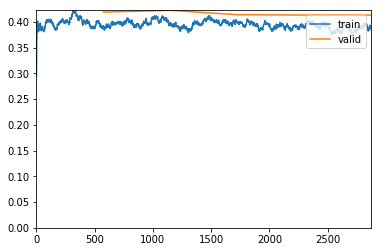

Better model found at epoch 0 with val_loss value: 0.41910460591316223.
Better model found at epoch 2 with val_loss value: 0.4140751361846924.
Better model found at epoch 3 with val_loss value: 0.4133813977241516.
Better model found at epoch 4 with val_loss value: 0.413217693567276.


In [198]:
lr = 1e-4
learn.fit_one_cycle(5,max_lr=lr,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [199]:
learn.save('densenet169-stage-4')

In [36]:
learn.load('densenet169-stage-4');

In [37]:
learn.purge()
learn.unfreeze()

In [202]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


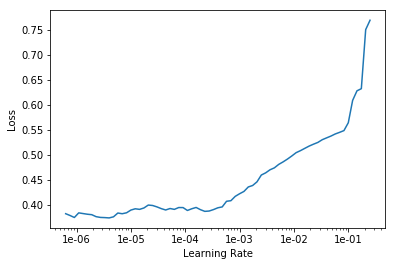

In [203]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.399317,0.413274,0.177979,0.822021,07:44
1,0.382611,0.417556,0.180794,0.819206,07:35
2,0.381057,0.419299,0.182671,0.817329,07:35
3,0.379243,0.414985,0.181107,0.818893,07:35
4,0.385076,0.415866,0.181107,0.818893,07:34


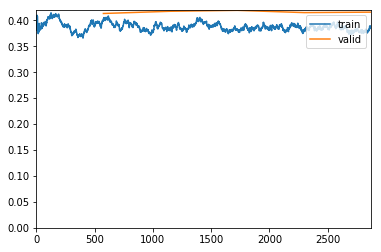

Better model found at epoch 0 with val_loss value: 0.4132744073867798.


In [38]:
lr=3e-5
learn.fit_one_cycle(5,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [39]:
learn.save('densenet169-stage-5')

#### Results by image

In [50]:
size = 224
bs = 64

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs,
                                  ).normalize(imagenet_stats)

In [51]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], wd=0.1)

In [52]:
learn.load('densenet169-stage-5');

In [53]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

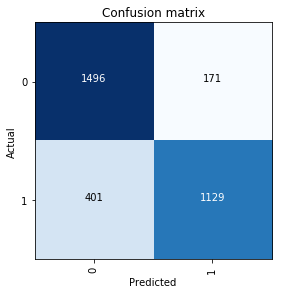

In [54]:
# first interpretation
interp.plot_confusion_matrix()

In [55]:
interp.most_confused(min_val=2)

[('1', '0', 401), ('0', '1', 171)]

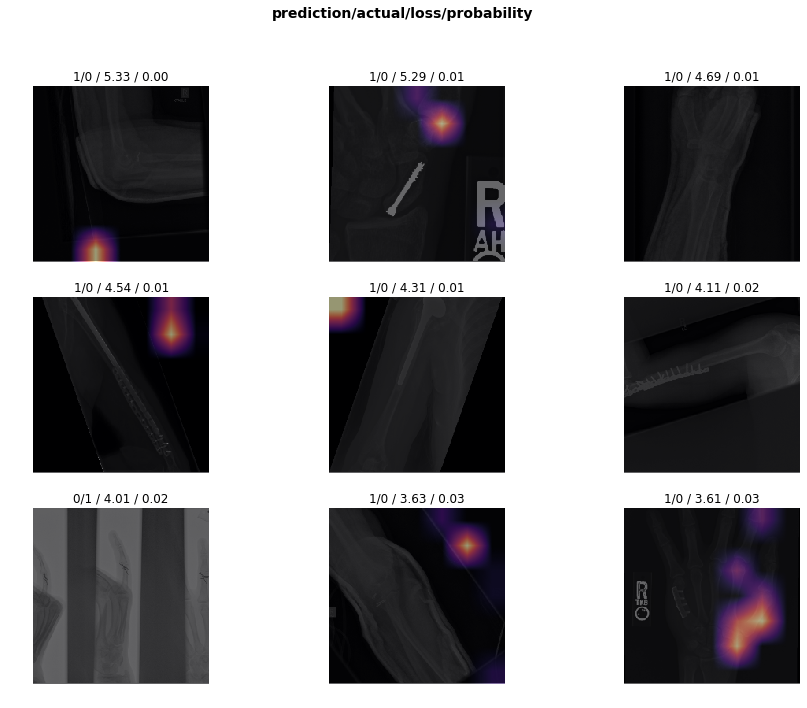

In [56]:
interp.plot_top_losses(9, figsize=(15,11))

#### Results by study

In [57]:
learn.load('densenet169-stage-5');

In [58]:
# validation
preds_val, y_val = learn.get_preds()

In [59]:
preds_val

tensor([[0.2387, 0.7613],
        [0.0067, 0.9933],
        [0.0238, 0.9762],
        ...,
        [0.7870, 0.2130],
        [0.9130, 0.0870],
        [0.6780, 0.3220]])

In [60]:
len(preds_val)

3197

In [61]:
for img_url in data.valid_ds.x.items:
    print(img_url)
    break

/home/jupyter/tutorials/data/MURA-v1.1/data2/valid/1/HAND_patient11538_study1_positive_image1.png


In [62]:
pat_label = re.compile(r'/([^/]+)_patient[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^_]+.png$')

In [75]:
%%time
studies = dict()
studies_num = dict()
labels_num = dict()

for m in mura:
    labels_num[m] = 0

for idx, src in enumerate(data.valid_ds.x.items):
    # get label name
    label = pat_label.search(str(src))
    label = label.group(1) 
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1) 
    # sum probabilities by study
    if study in studies:
        studies[study] += preds_val[idx,:].clone()
        studies_num[study] += 1
    else:
        studies[study] = preds_val[idx,:].clone()
        studies_num[study] = 1
    labels[study] = label

CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 49.9 ms


In [76]:
labels

{'HAND_patient11538_study1_positive': 'HAND',
 'FINGER_patient11480_study1_positive': 'FINGER',
 'ELBOW_patient11756_study1_positive': 'ELBOW',
 'ELBOW_patient11817_study1_positive': 'ELBOW',
 'WRIST_patient11206_study1_positive': 'WRIST',
 'HAND_patient11518_study1_positive': 'HAND',
 'ELBOW_patient11421_study1_positive': 'ELBOW',
 'SHOULDER_patient11707_study1_positive': 'SHOULDER',
 'FINGER_patient11910_study1_positive': 'FINGER',
 'FOREARM_patient11319_study1_positive': 'FOREARM',
 'HUMERUS_patient11645_study1_positive': 'HUMERUS',
 'SHOULDER_patient11245_study1_positive': 'SHOULDER',
 'SHOULDER_patient11549_study1_positive': 'SHOULDER',
 'HUMERUS_patient11608_study1_positive': 'HUMERUS',
 'FOREARM_patient11420_study1_positive': 'FOREARM',
 'HAND_patient11504_study1_positive': 'HAND',
 'WRIST_patient11225_study1_positive': 'WRIST',
 'FOREARM_patient11428_study1_positive': 'FOREARM',
 'SHOULDER_patient11735_study1_positive': 'SHOULDER',
 'SHOULDER_patient11738_study1_positive': 'SHO

In [77]:
labels_num = dict()
for m in mura:
    labels_num[m] = sum([1 for k,v in labels.items() if v.lower() == m])

In [78]:
print(labels_num)
print(sum([v for k,v in labels_num.items()]))

{'elbow': 158, 'finger': 175, 'forearm': 133, 'hand': 167, 'humerus': 135, 'shoulder': 194, 'wrist': 237}
1199


In [79]:
studies

{'HAND_patient11538_study1_positive': tensor([0.5983, 1.4017]),
 'FINGER_patient11480_study1_positive': tensor([0.0123, 1.9877]),
 'ELBOW_patient11756_study1_positive': tensor([0.1031, 3.8969]),
 'ELBOW_patient11817_study1_positive': tensor([1.7978, 3.2022]),
 'WRIST_patient11206_study1_positive': tensor([0.1145, 2.8855]),
 'HAND_patient11518_study1_positive': tensor([0.4981, 1.5019]),
 'ELBOW_patient11421_study1_positive': tensor([0.0960, 3.9040]),
 'SHOULDER_patient11707_study1_positive': tensor([2.7667, 2.2333]),
 'FINGER_patient11910_study1_positive': tensor([0.7905, 4.2095]),
 'FOREARM_patient11319_study1_positive': tensor([0.2813, 1.7187]),
 'HUMERUS_patient11645_study1_positive': tensor([0.0925, 1.9075]),
 'SHOULDER_patient11245_study1_positive': tensor([0.7355, 0.2645]),
 'SHOULDER_patient11549_study1_positive': tensor([0.0662, 3.9338]),
 'HUMERUS_patient11608_study1_positive': tensor([1.4433, 0.5567]),
 'FOREARM_patient11420_study1_positive': tensor([2.3107, 1.6893]),
 'HAND_p

In [80]:
len(studies)

1199

In [81]:
studies_num

{'HAND_patient11538_study1_positive': 2,
 'FINGER_patient11480_study1_positive': 2,
 'ELBOW_patient11756_study1_positive': 4,
 'ELBOW_patient11817_study1_positive': 5,
 'WRIST_patient11206_study1_positive': 3,
 'HAND_patient11518_study1_positive': 2,
 'ELBOW_patient11421_study1_positive': 4,
 'SHOULDER_patient11707_study1_positive': 5,
 'FINGER_patient11910_study1_positive': 5,
 'FOREARM_patient11319_study1_positive': 2,
 'HUMERUS_patient11645_study1_positive': 2,
 'SHOULDER_patient11245_study1_positive': 1,
 'SHOULDER_patient11549_study1_positive': 4,
 'HUMERUS_patient11608_study1_positive': 2,
 'FOREARM_patient11420_study1_positive': 4,
 'HAND_patient11504_study1_positive': 2,
 'WRIST_patient11225_study1_positive': 3,
 'FOREARM_patient11428_study1_positive': 2,
 'SHOULDER_patient11735_study1_positive': 4,
 'SHOULDER_patient11738_study1_positive': 4,
 'ELBOW_patient11603_study1_positive': 2,
 'WRIST_patient11216_study1_positive': 5,
 'HAND_patient11502_study1_positive': 4,
 'WRIST_pat

In [82]:
len(studies_num)

1199

In [83]:
# get averages
for (k,v) in studies.items():
    studies[k] = studies[k] / studies_num[k]

In [84]:
studies

{'HAND_patient11538_study1_positive': tensor([0.2991, 0.7009]),
 'FINGER_patient11480_study1_positive': tensor([0.0062, 0.9938]),
 'ELBOW_patient11756_study1_positive': tensor([0.0258, 0.9742]),
 'ELBOW_patient11817_study1_positive': tensor([0.3596, 0.6404]),
 'WRIST_patient11206_study1_positive': tensor([0.0382, 0.9618]),
 'HAND_patient11518_study1_positive': tensor([0.2490, 0.7510]),
 'ELBOW_patient11421_study1_positive': tensor([0.0240, 0.9760]),
 'SHOULDER_patient11707_study1_positive': tensor([0.5533, 0.4467]),
 'FINGER_patient11910_study1_positive': tensor([0.1581, 0.8419]),
 'FOREARM_patient11319_study1_positive': tensor([0.1406, 0.8594]),
 'HUMERUS_patient11645_study1_positive': tensor([0.0462, 0.9538]),
 'SHOULDER_patient11245_study1_positive': tensor([0.7355, 0.2645]),
 'SHOULDER_patient11549_study1_positive': tensor([0.0166, 0.9834]),
 'HUMERUS_patient11608_study1_positive': tensor([0.7216, 0.2784]),
 'FOREARM_patient11420_study1_positive': tensor([0.5777, 0.4223]),
 'HAND_p

In [85]:
# get predictions by study
acc = 0.
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    if 'negative' in k:
        acc += (0 == y_hat.item())
    else:
        acc += (1 == y_hat.item())
    # print(f'{k} {y_hat.item()} ({prob})')

In [86]:
len(studies), acc

(1199, 994.0)

In [87]:
# get study accuracy total
print(f'study accuracy total: {round(acc / len(studies),3)}')

study accuracy total: 0.829


In [88]:
# get predictions by study and label
acc_label = dict()
for m in mura:
    acc_label[m] = 0
    
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    label = labels[k]
    if 'negative' in k:
        acc_label[label.lower()] += (0 == y_hat.item())
    else:
        acc_label[label.lower()] += (1 == y_hat.item())

In [89]:
acc_label

{'elbow': 137,
 'finger': 137,
 'forearm': 113,
 'hand': 134,
 'humerus': 117,
 'shoulder': 149,
 'wrist': 207}

In [90]:
sum([v for k,v in acc_label.items()])

994

In [91]:
labels_num

{'elbow': 158,
 'finger': 175,
 'forearm': 133,
 'hand': 167,
 'humerus': 135,
 'shoulder': 194,
 'wrist': 237}

In [92]:
# get study accuracy by label
for m in mura:
    print(f'{m}: {round(acc_label[m] / labels_num[m],3)}')

elbow: 0.867
finger: 0.783
forearm: 0.85
hand: 0.802
humerus: 0.867
shoulder: 0.768
wrist: 0.873
